# Air Quality EDA and LSTM Preparation

Tujuan notebook ini:
- Memuat dan membersihkan dataset AirQuality
- Eksplorasi data (time plot, resampling, korelasi)
- Seasonal decomposition (jika paket tersedia)
- ACF/PACF (jika paket tersedia)
- Demo windowing (sekuens) sesuai input LSTM


In [4]:
# Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Optional: seasonal decomposition & ACF/PACF
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
except Exception:
    seasonal_decompose = None

try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
except Exception:
    plot_acf = plot_pacf = None

DATA_PATH = Path('AirQuality.csv')
assert DATA_PATH.exists(), 'AirQuality.csv tidak ditemukan di direktori kerja.'


In [5]:
# Load & Clean

df = pd.read_csv('AirQuality.csv', sep=';')

# Drop unnamed cols
for col in ['Unnamed: 15', 'Unnamed: 16']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Convert comma decimals to dot for select columns
comma_cols = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in comma_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Other numeric
other_numeric = ['PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
                 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
for col in other_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# DateTime index
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.set_index('DateTime').drop(columns=['Date', 'Time'])

# Drop NaN rows
df = df.dropna()

# Filter -200 sentinel
target_col = 'CO(GT)'
feature_cols = ['PT08.S1(CO)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH']
mask = (df[target_col] != -200) & (df[target_col] > 0)
for col in feature_cols:
    mask &= (df[col] != -200) & (df[col] > 0)

df_clean = df[mask].copy()

print('Rows after cleaning:', len(df_clean))
df_clean.head()


Rows after cleaning: 6929


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Date range: 2004-03-10 18:00:00 -> 2005-04-04 14:00:00
Frequency (infer): None

Describe:


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000,6929.000000
mean,2.184688,1120.392697,-148.555636,10.567138,959.144898,250.813682,816.166113,113.915572,1453.902006,1058.546111,17.787242,48.894761,0.986854
std,1.440995,218.554123,157.198176,7.463603,263.729409,208.673789,251.060658,47.467324,352.245850,406.116694,8.819181,17.443602,0.400257
min,0.100000,647.000000,-200.000000,0.200000,397.000000,2.000000,322.000000,2.000000,602.000000,252.000000,0.200000,9.200000,0.186200
25%,1.100000,958.000000,-200.000000,4.900000,760.000000,103.000000,642.000000,79.000000,1208.000000,760.000000,11.200000,35.300000,0.695000
50%,1.900000,1085.000000,-200.000000,8.800000,931.000000,186.000000,785.000000,110.000000,1458.000000,1007.000000,16.900000,49.200000,0.954700
75%,2.900000,1254.000000,-200.000000,14.600000,1136.000000,335.000000,945.000000,142.000000,1683.000000,1323.000000,23.700000,62.200000,1.252800
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


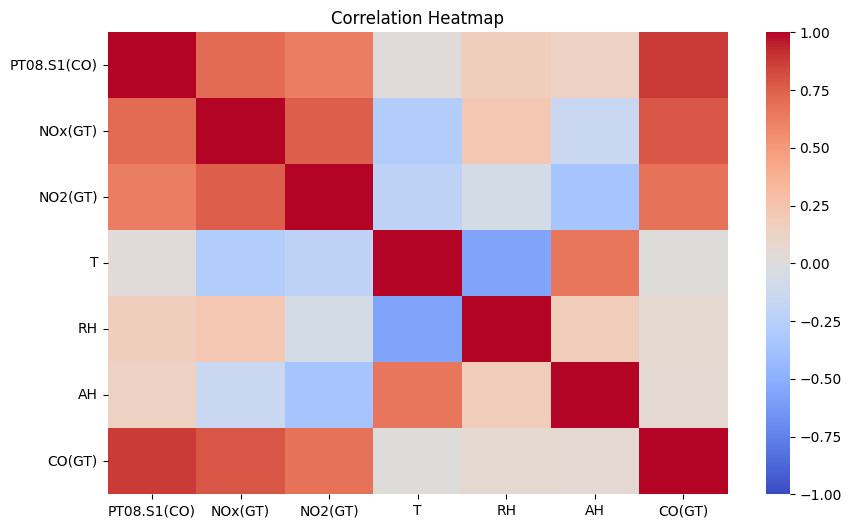

In [6]:
# Basic EDA: overview
print('Date range:', df_clean.index.min(), '->', df_clean.index.max())
print('Frequency (infer):', pd.infer_freq(df_clean.index))
print('\nDescribe:')
display(df_clean.describe())

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_clean[feature_cols + [target_col]].corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


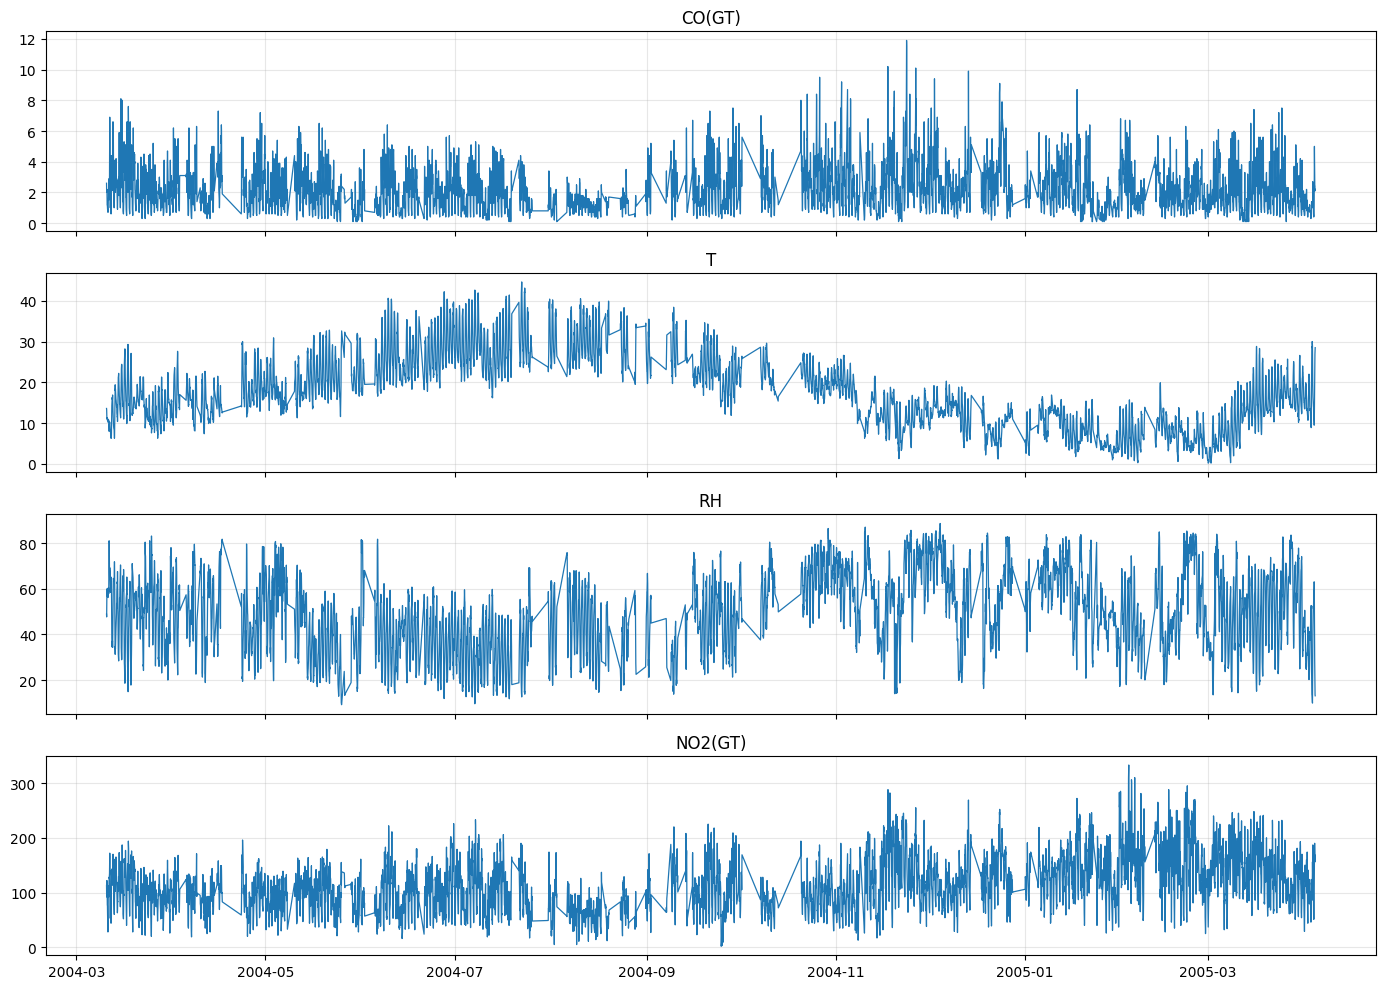

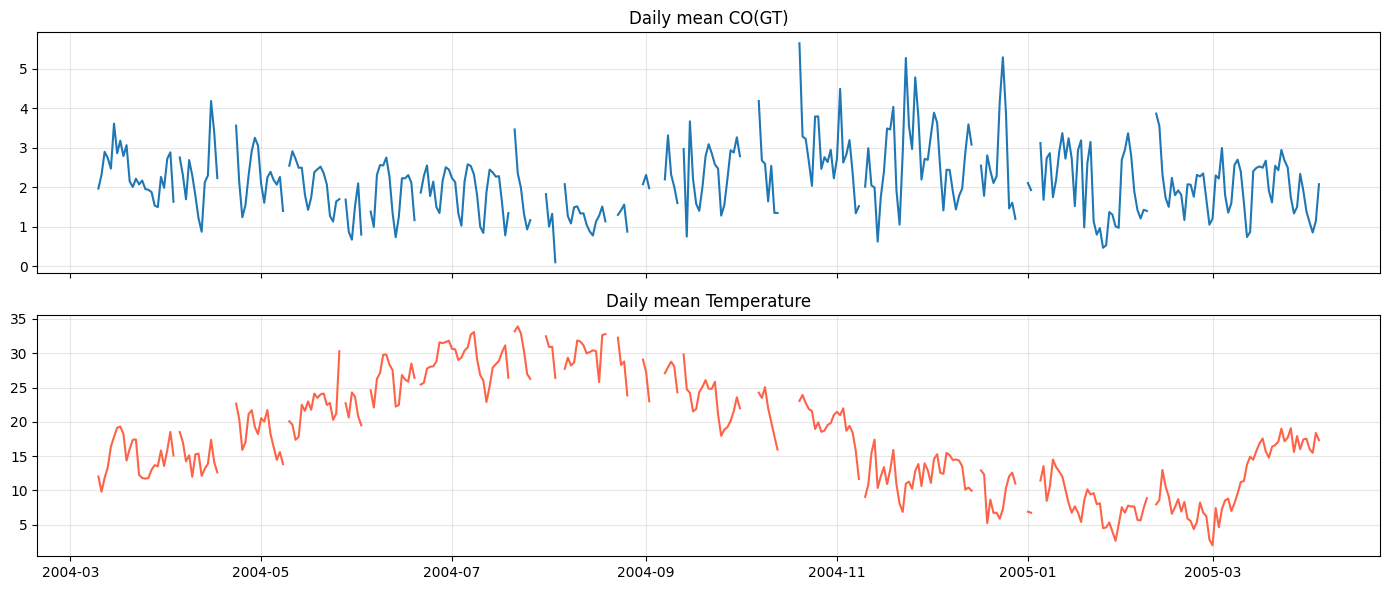

In [7]:
# Time plots
fig, axes = plt.subplots(4, 1, figsize=(14,10), sharex=True)
for ax, col in zip(axes, [target_col, 'T', 'RH', 'NO2(GT)']):
    ax.plot(df_clean.index, df_clean[col], linewidth=0.9)
    ax.set_title(col)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resampling (daily mean)
daily = df_clean.resample('D').mean(numeric_only=True)
fig, axes = plt.subplots(2, 1, figsize=(14,6), sharex=True)
axes[0].plot(daily.index, daily[target_col])
axes[0].set_title(f'Daily mean {target_col}')
axes[0].grid(True, alpha=0.3)
axes[1].plot(daily.index, daily['T'], color='tomato')
axes[1].set_title('Daily mean Temperature')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
# Seasonal Decomposition (optional if statsmodels available)
if seasonal_decompose is not None:
    try:
        daily_target = daily[target_col].dropna()
        # Fill small gaps for decomposition
        daily_target = daily_target.interpolate(limit_direction='both')
        res = seasonal_decompose(daily_target, model='additive', period=7)
        fig = res.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle('Seasonal Decomposition (Daily, period=7)', y=1.02)
        plt.show()
    except Exception as e:
        print('Seasonal decomposition skipped:', e)
else:
    print('statsmodels not available, skip seasonal decomposition')


statsmodels not available, skip seasonal decomposition


In [16]:
# ACF/PACF (optional)
if plot_acf is not None and plot_pacf is not None:
    try:
        from matplotlib import gridspec
        series = daily[target_col].dropna().astype(float)
        fig = plt.figure(figsize=(12,5))
        gs = gridspec.GridSpec(1, 2)
        ax1 = fig.add_subplot(gs[0,0])
        plot_acf(series, ax=ax1, lags=40, title='ACF - Daily CO(GT)')
        ax2 = fig.add_subplot(gs[0,1])
        plot_pacf(series, ax=ax2, lags=40, title='PACF - Daily CO(GT)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('ACF/PACF skipped:', e)
else:
    print('statsmodels not available, skip ACF/PACF')


statsmodels not available, skip ACF/PACF


X_demo shape: (6905, 24, 6) | y_demo shape: (6905,)
LSTM expects: (samples, timesteps, features) = (6905, 24, 6)


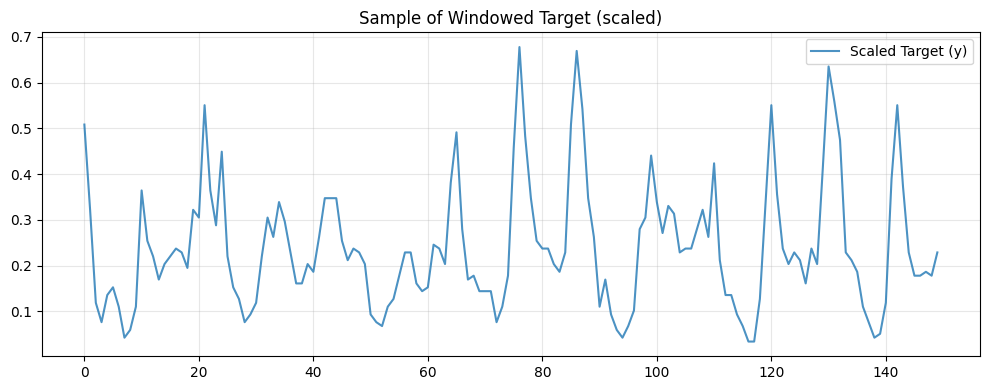

In [17]:
# Scaling & Windowing demo (align with lstm_model.py)
scaler = MinMaxScaler()
arr = df_clean[feature_cols + [target_col]].values
arr_scaled = scaler.fit_transform(arr)

SEQ_LEN = 24

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

X_demo, y_demo = create_sequences(arr_scaled, SEQ_LEN)
print('X_demo shape:', X_demo.shape, '| y_demo shape:', y_demo.shape)
print('LSTM expects: (samples, timesteps, features) =', X_demo.shape)

# Quick sanity plot on a small slice
n = min(150, len(y_demo))
plt.figure(figsize=(10,4))
plt.plot(y_demo[:n], label='Scaled Target (y)', alpha=0.8)
plt.title('Sample of Windowed Target (scaled)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# Training setup: sequences, split, and model definition
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

# Gunakan array terstandarisasi yang sudah dibuat di atas
# arr_scaled dari df_clean[feature_cols + [target_col]]
SEQ_LEN = 24

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # semua fitur kecuali target
        y.append(data[i, -1])               # kolom target (scaled)
    return np.array(X), np.array(y)

X, y = create_sequences(arr_scaled, SEQ_LEN)
print('Sequences:', X.shape, y.shape)

# Split train/val/test (60/20/20)
train_ratio, val_ratio = 0.6, 0.2
n = len(X)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

print('Train:', X_train.shape, '| Val:', X_val.shape, '| Test:', X_test.shape)

# Build model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()



Sequences: (6905, 24, 6) (6905,)
Train: (4143, 24, 6) | Val: (1381, 24, 6) | Test: (1381, 24, 6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            11400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                       

Epoch 1/30


130/130 [==============================] - 21s 88ms/step - loss: 0.0129 - mae: 0.0865 - val_loss: 0.0178 - val_mae: 0.1029
Epoch 2/30
130/130 [==============================] - 9s 68ms/step - loss: 0.0106 - mae: 0.0774 - val_loss: 0.0178 - val_mae: 0.1098
Epoch 3/30
130/130 [==============================] - 9s 69ms/step - loss: 0.0101 - mae: 0.0753 - val_loss: 0.0147 - val_mae: 0.0966
Epoch 4/30
130/130 [==============================] - 9s 68ms/step - loss: 0.0093 - mae: 0.0722 - val_loss: 0.0183 - val_mae: 0.1095
Epoch 5/30
130/130 [==============================] - 8s 63ms/step - loss: 0.0087 - mae: 0.0695 - val_loss: 0.0140 - val_mae: 0.0951
Epoch 6/30
130/130 [==============================] - 3s 25ms/step - loss: 0.0081 - mae: 0.0666 - val_loss: 0.0129 - val_mae: 0.0920
Epoch 7/30
130/130 [==============================] - 10s 76ms/step - loss: 0.0076 - mae: 0.0639 - val_loss: 0.0111 - val_mae: 0.0796
Epoch 8/30
130/130 [==============================] - 9s 69ms/ste

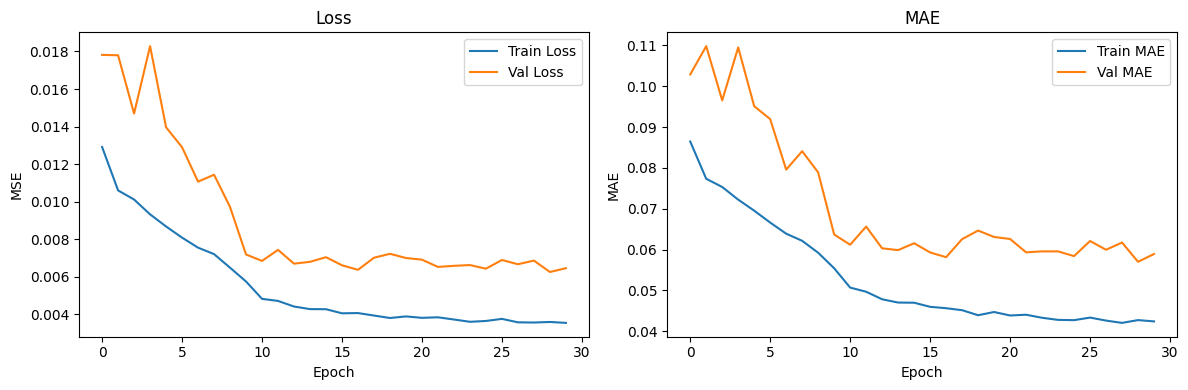

In [19]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend(); plt.title('MAE'); plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.tight_layout(); plt.show()


44/44 [==============================] - 3s 24ms/step
RMSE: 0.8465 | MAE: 0.6930


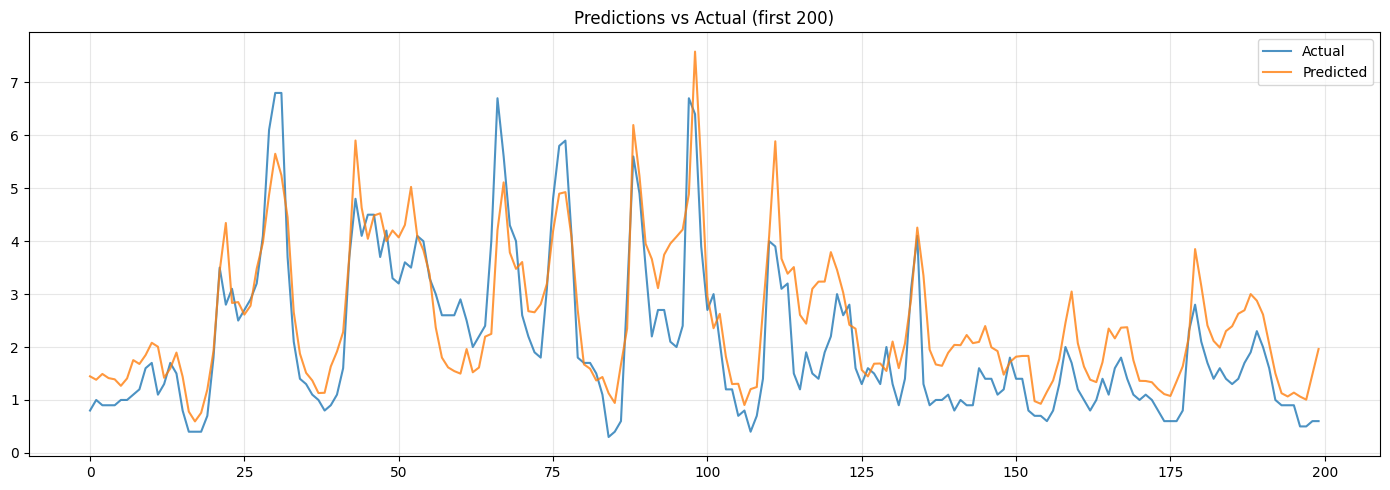

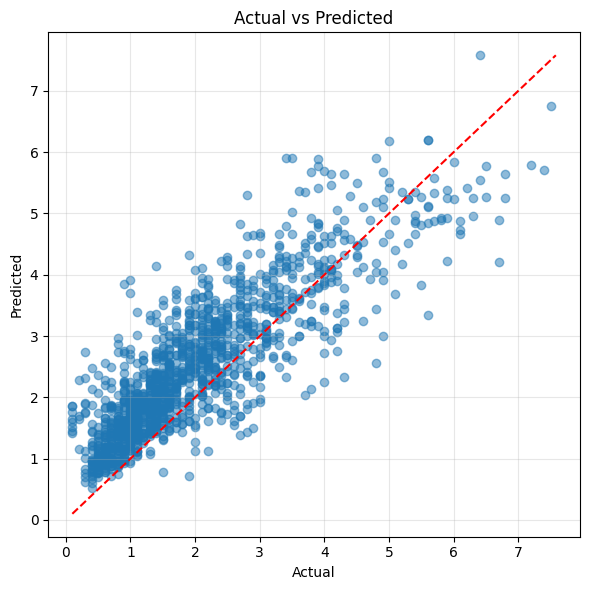

Saved: lstm_air_quality_model.h5, scaler.pkl


In [20]:
# Evaluate, inverse transform, and save artifacts
# Predict
y_pred = model.predict(X_test)

# Inverse transform: siapkan dummy array agar scaler bisa di-inverse
num_feats = len(feature_cols)
dummy_pred = np.zeros((len(y_pred), num_feats + 1))
dummy_pred[:, -1] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(dummy_pred)[:, -1]

dummy_true = np.zeros((len(y_test), num_feats + 1))
dummy_true[:, -1] = y_test
y_true_inv = scaler.inverse_transform(dummy_true)[:, -1]

# Metrics
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
print(f'RMSE: {rmse:.4f} | MAE: {mae:.4f}')

# Plots
plt.figure(figsize=(14,5))
n_plot = min(200, len(y_true_inv))
plt.plot(y_true_inv[:n_plot], label='Actual', alpha=0.8)
plt.plot(y_pred_inv[:n_plot], label='Predicted', alpha=0.8)
plt.title('Predictions vs Actual (first 200)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_true_inv, y_pred_inv, alpha=0.5)
mn, mx = min(y_true_inv.min(), y_pred_inv.min()), max(y_true_inv.max(), y_pred_inv.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Actual vs Predicted')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Save model & scaler
model.save('lstm_air_quality_model.h5')
joblib.dump(scaler, 'scaler.pkl')
print('Saved: lstm_air_quality_model.h5, scaler.pkl')
